In [93]:
import torch
import torchvision


In [94]:
from PIL import Image

animalpic = Image.open("C:/Data/ap-10k/data/000000000001.jpg")
animalpic.show()

In [95]:
import json
from xtcocotools.coco import COCO

# annotations1 = open("C:/Data/ap-10k/annotations/ap10k-test-split1.json")
# data = json.load(annotations1)

cocoann = COCO("C:/Data/ap-10k/annotations/ap10k-test-split1.json")
for cat in cocoann.loadCats(1): # categories
    print(cat)
    print(cat["skeleton"])
    print(cat["keypoints"])
    print(cat["keypoints"][0])
    print(cat["skeleton"][0])


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
{'id': 1, 'name': 'antelope', 'supercategory': 'Bovidae', 'keypoints': ['left_eye', 'right_eye', 'nose', 'neck', 'root_of_tail', 'left_shoulder', 'left_elbow', 'left_front_paw', 'right_shoulder', 'right_elbow', 'right_front_paw', 'left_hip', 'left_knee', 'left_back_paw', 'right_hip', 'right_knee', 'right_back_paw'], 'skeleton': [[1, 2], [1, 3], [2, 3], [3, 4], [4, 5], [4, 6], [6, 7], [7, 8], [4, 9], [9, 10], [10, 11], [5, 12], [12, 13], [13, 14], [5, 15], [15, 16], [16, 17]]}
[[1, 2], [1, 3], [2, 3], [3, 4], [4, 5], [4, 6], [6, 7], [7, 8], [4, 9], [9, 10], [10, 11], [5, 12], [12, 13], [13, 14], [5, 15], [15, 16], [16, 17]]
['left_eye', 'right_eye', 'nose', 'neck', 'root_of_tail', 'left_shoulder', 'left_elbow', 'left_front_paw', 'right_shoulder', 'right_elbow', 'right_front_paw', 'left_hip', 'left_knee', 'left_back_paw', 'right_hip', 'right_knee', 'right_back_paw']
left_eye
[1, 2]


In [96]:
import json
from xtcocotools.coco import COCO
import ap10k_info
from dataset_info import DatasetInfo

# annotations1 = open("C:/Data/ap-10k/annotations/ap10k-test-split1.json")
# data = json.load(annotations1)

coco = COCO("C:/Data/ap-10k/annotations/ap10k-test-split1.json")
if 'categories' in coco.dataset:    # categories from dataset
        cats = [
            cat['name']
            for cat in coco.loadCats(coco.getCatIds())
        ]
        classes = cats  # = animals
        num_classes = len(classes)  # num animals
        class_to_ind = dict(    # dict in form [animal name: 0], [animal name: 1]
            zip(classes, range(num_classes)))
        class_to_coco_ind = dict(   # dict in form [animal name: 1], [animal name: 2]
            zip(cats, coco.getCatIds()))
        coco_ind_to_class_ind = dict(
        (class_to_coco_ind[cls], class_to_ind[cls])
        for cls in classes[1:])
        #print(class_to_ind)


coco_img = coco.loadImgs(coco.getImgIds())[0]
height = coco_img["height"]
width = coco_img["width"]
ann_ids = coco.getAnnIds(imgIds=coco.getImgIds()[0], iscrowd=False)
objs = coco.loadAnns(ann_ids)
print(objs)

valid_objs = [] # check if bounding boxes are valid (in height x width range)
for obj in objs:
    if 'bbox' not in obj:
        continue
    x, y, w, h = obj['bbox']
    x1 = max(0, x)
    y1 = max(0, y)
    x2 = min(width - 1, x1 + max(0, w - 1))
    y2 = min(height - 1, y1 + max(0, h - 1))
    if ('area' not in obj or obj['area'] > 0) and x2 > x1 and y2 > y1:
        obj['clean_bbox'] = [x1, y1, x2 - x1, y2 - y1]
        valid_objs.append(obj)
objs = valid_objs   # objects with valid bounding boxes

print(objs[0]["bbox"])  # format x pixel, y pixel, width of bbox, height of bbox    (pixel coord of top left corner)

dataset_info = ap10k_info.dataset_info
dataset_info = DatasetInfo(dataset_info)
num_joints = dataset_info.keypoint_num

#for ann in coco.loadAnns(cocoann.getCatIds()): # categories
#    print("1")


ModuleNotFoundError: No module named 'ap10k_info'

In [ ]:
import numpy as np

def xywh2cs(self, x, y, w, h, padding=1.25):
    """This encodes bbox(x,y,w,h) into (center, scale)

    Args:
        x, y, w, h (float): left, top, width and height
        padding (float): bounding box padding factor

    Returns:
        center (np.ndarray[float32](2,)): center of the bbox (x, y).
        scale (np.ndarray[float32](2,)): scale of the bbox w & h.
    """
    aspect_ratio = self.image_width * 1.0 / self.image_height
    center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

    if self.is_train and np.random.rand() < 0.3:    # ? random manipulation to data, maybe ?
        center += 0.4 * (np.random.rand(2) - 0.5) * [w, h]

    # set aspect ration correctly
    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio

    # pixel std is 200.0
    scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
    # padding to include proper amount of context
    scale = scale * padding

    return center, scale

def _get_mapping_id_name(imgs):
    """
    Args:
        imgs (dict): dict of image info.

    Returns:
        tuple: Image name & id mapping dicts.

        - id2name (dict): Mapping image id to name.
        - name2id (dict): Mapping image name to id.
    """
    id2name = {}
    name2id = {}
    for image_id, image in imgs.items():
        file_name = image['file_name']
        id2name[image_id] = file_name
        name2id[file_name] = image_id

    return id2name, name2id


In [ ]:
import numpy as np
import os

bbox_id = 0
rec = []
id2Cat = []
for obj in objs:
    if 'keypoints' not in obj:  # if no keypoints
        continue

    if max(obj['keypoints']) == 0:  # if max amount of keypoints = 0
        continue

    if 'num_keypoints' in obj and obj['num_keypoints'] == 0:    # if num keypoints = 0
        continue

    joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
    joints_3d_visible = np.zeros((num_joints, 3), dtype=np.float32) # make new arrays in same shape as num_joints but in 3d

    keypoints = np.array(obj['keypoints']).reshape(-1, 3)   # creating the keypoint array
    print(keypoints)
    print(keypoints.__len__())

    #keypoints = keypoints[ap10k2coco]
    joints_3d[:, :2] = keypoints[:, :2]
    joints_3d_visible[:, :2] = np.minimum(1, keypoints[:, 2:3]) # fill the 3d joints array with the keypoints
    print(joints_3d)

    center, scale = xywh2cs(*obj['clean_bbox'][:4]) #changes bbox to center of bbox (x,y) and scale (w,h)

    id2name, name2id = _get_mapping_id_name(coco.imgs)
    rootpath = "C:/Data/ap-10k/"
    image_file = os.path.join(rootpath, 'data', id2name[img_id])
    rec.append({
        'image_file': image_file,
        'center': center,
        'scale': scale,
        'bbox': obj['clean_bbox'][:4],
        'joints_3d': joints_3d,
        'joints_3d_visible': joints_3d_visible,
        'bbox_score': 1,
        'bbox_id': bbox_id
    })

    category = obj['category_id']
    
    id2Cat.append({
        'image_file': image_file,
        'bbox_id': bbox_id,
        'category': category,
    })
    bbox_id = bbox_id + 1

print(rec, id2Cat)


In [99]:
from dataset.ap10k import AnimalAP10KDataset
from config import _C
cfg = _C.clone()
#cfg.merge_from_file("cfg.yaml")
cfg.freeze()
data = AnimalAP10KDataset(cfg, "C:/Data/ap-10k/", 'train', 1, None)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [ ]:
x = 0
for i in range(0,0,1):
    x = x + 1
    print("stuff")

print(x)

0


In [ ]:
filters_out = (128,64,32,16)
#filters_out = sorted(filters_out)
filters_in = 64
print(sorted(filters_out,reverse=True))
print((sorted(filters_out).index(filters_in)))

[128, 64, 32, 16]
2


In [ ]:
my_dict = {}
filter_out = 32
mylist = [1,2,3]

my_dict[filter_out]=mylist

print(my_dict)

{32: [1, 2, 3]}


In [ ]:
from basic_models import *

filters_out = [64,32,128,16]
filter_in = 32
use_csdlkcb = True

m = {}
for filter_out in filters_out:
    if filter_in < filter_out:
        
        down = []
        sort = sorted(filters_out,reverse=True)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            down.append(Downsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))
            
            if sort[ind_filt_in-i-1] == filter_out:
                break
    
        m[filter_out] = down

    if filter_in > filter_out:
        
        up = []
        sort = sorted(filters_out)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            up.append(TransposedUpsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))

            if sort[ind_filt_in-i-1] == filter_out:
                break

        m[filter_out] = up

    if filter_in == filter_out:
        if use_csdlkcb:
            m[filter_out] = CSDLKCB(filter_in,filter_out)
        else:
            m[filter_out] = ConvBlock(filter_in,filter_out)

print(m)

{64: [Downsample(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)], 32: CSDLKCB(
  (pad): ReflectionPad2d((4, 4, 4, 4))
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (shuffle): ChannelShuffle()
  (dwconv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32)
  (dwdconv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3), groups=32)
  (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
), 128: [Downsample(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
), Downsample(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)], 16: [TransposedUpsample(
  (csdlkcb): CSDLKCB(
    (pad): ReflectionPad2d((60, 60, 60, 60))
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (shuffle): ChannelShuffle()
    (dwconv): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), groups=32)
    (dwdconv): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), dilation=(

In [ ]:
filters_in = [128,64,32,16]
filter_out = 32
use_csdlkcb = True


filters_in = sorted(filters_in,reverse=True)

#self.filters_in = filters_in

m = {}
for filter_in in filters_in:
    if filter_in < filter_out:
        
        down = []
        sort = sorted(filters_in,reverse=True)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            down.append(Downsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))
            
            if sort[ind_filt_in-i-1] == filter_out:
                break
    
        m[filter_in] = nn.Sequential(*down)

    if filter_in > filter_out:
        
        up = []
        sort = sorted(filters_in)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            up.append(TransposedUpsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))

            if sort[ind_filt_in-i-1] == filter_out:
                break

        m[filter_in] = nn.Sequential(*up)

    if filter_in == filter_out:
        if use_csdlkcb:
            m[filter_in] = CSDLKCB(filter_in,filter_out)
        else:
            m[filter_in] = ConvBlock(filter_in,filter_out)

print(m)

{128: Sequential(
  (0): TransposedUpsample(
    (csdlkcb): CSDLKCB(
      (pad): ReflectionPad2d((60, 60, 60, 60))
      (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (shuffle): ChannelShuffle()
      (dwconv): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), groups=128)
      (dwdconv): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), dilation=(11, 11), groups=128)
      (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (up): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  )
  (1): TransposedUpsample(
    (csdlkcb): CSDLKCB(
      (pad): ReflectionPad2d((60, 60, 60, 60))
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (shuffle): ChannelShuffle()
      (dwconv): Conv2d(64, 64, kernel_size=(11, 11), stride=(1, 1), groups=64)
      (dwdconv): Conv2d(64, 64, kernel_size=(11, 11), stride=(1, 1), dilation=(11, 11), groups=64)
      (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (up)

In [ ]:
filters_in = [128,64,32,16]
filter_out = 32
use_csdlkcb = True
filters_out = sorted(filters_out,reverse=True)

#self.filters_out = filters_out

m = {}
for filter_out in filters_out:
    if filter_in < filter_out:
        
        down = []
        sort = sorted(filters_out,reverse=True)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            down.append(Downsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))
            
            if sort[ind_filt_in-i-1] == filter_out:
                break
    
        m[filter_out] = nn.Sequential(*down)

    if filter_in > filter_out:
        
        up = []
        sort = sorted(filters_out)
        ind_filt_in = sort.index(filter_in)  
        for i in range(ind_filt_in):
            if i == -1:
                i = 0


            up.append(TransposedUpsample(sort[ind_filt_in-i],sort[ind_filt_in-i-1]))

            if sort[ind_filt_in-i-1] == filter_out:
                break

        m[filter_out] = nn.Sequential(*up)

    if filter_in == filter_out:
        if use_csdlkcb:
            m[filter_out] = CSDLKCB(filter_in,filter_out)
        else:
            m[filter_out] = ConvBlock(filter_in,filter_out)

self.m = m

NameError: name 'self' is not defined

In [100]:
import einops
tens = data.__getitem__(1)
#print(tens[0])  # input image as np array
#print(tens[1].type())   # target array as tensor    target is a heatmap    target is a (17,64,64) sized tensor
#print(tens[2].type())   # target weight
#print(tens[3])          # metadata dict


tesn = torch.from_numpy(tens[0])
print(tesn.size())
tesn = einops.rearrange(tesn, "h w d -> d h w")
print(tesn.size())



torch.Size([512, 512, 3])
torch.Size([3, 512, 512])


In [193]:
tens3 = torch.rand(3,512,512)
out = tens3.size()
print(out)
numout = 1
for num in out:
    numout = numout * num

print(numout)

torch.Size([3, 512, 512])
786432


In [244]:
import torch

# tens1 = torch.rand((3,512,512))
# tens2 = torch.rand((3,512,512))

tens1 = torch.rand((3,512,512))
tens2 = torch.rand((3,512,512))

numout = 1
for num in out:
    numout = numout * num

out = torch.isclose(tens1,tens2)
out = out.sum()
out = torch.div(out, numout)

print(out)

tensor(1.2716e-05)


In [101]:
tensor = torch.sum(tens[1], dim=0)
tensor = tensor.unsqueeze(0)
print(tensor.size())
print(tensor.max())


torch.Size([1, 256, 256])
tensor(1.)


In [103]:
tens1d = tens[1].split(1, 0)
print(tens1d[0].size())

torch.Size([1, 256, 256])


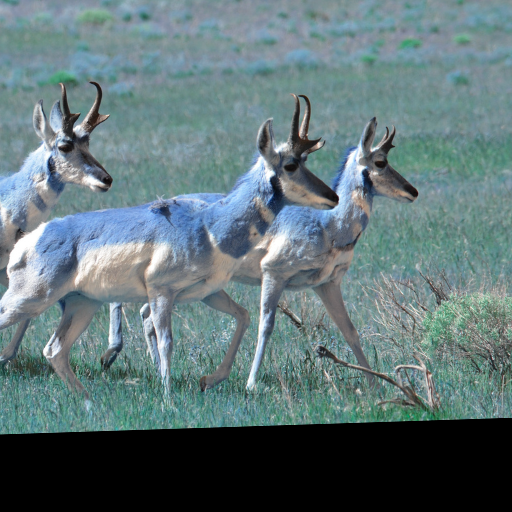

In [102]:
Image.fromarray(tens[0])

In [109]:
from PIL import Image
import torchvision.transforms as T
import torch
#image = tens1d[10]
image = 0
for tesns in tens1d:
    image = torch.add(image,tesns)
transform = T.ToPILImage()
#image = imgtens[0].squeeze(0)
image = transform(image)
image.show()


In [ ]:
features_in = (128,64,32,16)

num_in = len(features_in)
print(num_in)

4


In [97]:
from basic_models import MultiResampleMultipleToOne

ImportError: cannot import name 'MultiResampleMultipleToOne' from 'basic_models' (c:\Users\Redmi\Documents\Programming\Neural Networks\Animal_Pose_Estimation\basic_models.py)